# ClinicalTrialOptm.jl

## The Problem

In the last five years, clinical trials have become increasingly more difficult to conduct due to staffing, budget, and protocol complications. According to the 2020 Tufts University Impact Report, more than 20% of clinical trials fail to recruit enough patients in time. Biomedical and phameceutical companies rely on trial data to progress in treatment development, making effective clinical trial design necessary to address.

ClinicalTrialOptm.jl solves these multi-center, multi-state recruitment problems using mixed-integer algorithms. It seeks to optimize the number of clinics for each country, minimizing cost while maintaining high probabilities of successful recruitment. Details on the calculations are described in the paper: (paper not finished yet)

## Installation

ClinicalTrialOptm.jl requires Julia v1.7 or later. The package has not been registered yet and must be installed using the repository location. To do so, start Julia and use the `]` key to switch to the package manager REPL:

```{julia}
(@v1.8) Pkg> add https://github.com/Hua-Zhou/ClinicalTrialOptm.jl.git
```

Use the backspace key to return to the Julia REPL.

In [1]:
versioninfo()

Julia Version 1.8.1
Commit afb6c60d69a (2022-09-06 15:09 UTC)
Platform Info:
  OS: macOS (arm64-apple-darwin21.5.0)
  CPU: 8 × Apple M1
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, apple-m1)
  Threads: 4 on 4 virtual cores
Environment:
  JULIA_NUM_THREADS = 4


In [2]:
# for use in this tutorial
using ClinicalTrialOptm
using Distributions, HiGHS, SCS, Pajarito, SCIP, MathOptInterface, JuMP, Plots, StatsPlots
const MOI = MathOptInterface;

## Inputting Parameters

There are two types of data structs within this package: `Country` and `ClinicalTrial`:

### `Country`

```@docs
Country
```

Example use:

In [3]:
m = 1.5
s² = 2.0
l, u = 0, 10
c₀ = 20_000.0
c = 5_000.0
q = 1_500.0
d = 0.05
T₀ = Uniform(0.0, 6.0)
Td = 24.0
ctry = Country(m, s², l, u, c₀, c, q, d, T₀, Td)

Country{Float64}(1.5, 2.0, 0, 10, 20000.0, 5000.0, 1500.0, 0.05, Uniform{Float64}(a=0.0, b=6.0), 24.0)

### `ClinicalTrial`

```@docs 
ClinicalTrial
```

Example use:

In [4]:
m = [1, 1.2, 1.4, 1.2]
s² = [0.2, 0.4, 0.8, 0.6]
l = [0, 3, 2, 1]
u = [8, 5, 7, 4]
c₀ = [15000.0, 13000.0, 16000.0, 17000.0]
c = [3000.0, 2000.0, 5000.0, 8000.0]
q = [1000.0, 1300.0, 900.0, 800.0]
d = [0.01, 0.05, 0.09, 0.15]
T₀ = fill(Uniform(0.0, 6.0), 4)
Td = 24.0
ct = ClinicalTrial(m, s², l, u, c₀, c, q, d, T₀, Td)


Global Clinical Trial:

Optimal center assignment not computed.
┌─────────┬─────────┬────────┬────────────┬────────────────┬──────────────┬───────────────┬──────────────┬──────────────┬─────────┐
│ Country │ mean(λ) │ var(λ) │ init. cost │    maint. cost │ enroll. cost │ drop out rate │ min. centers │ max. centers │ centers │
│         │         │        │   $/center │ $/center/month │    $/patient │               │              │              │         │
├─────────┼─────────┼────────┼────────────┼────────────────┼──────────────┼───────────────┼──────────────┼──────────────┼─────────┤
│       1 │    1.00 │   0.20 │      15000 │           3000 │         1000 │          0.01 │            0 │            8 │      NA │
│       2 │    1.20 │   0.40 │      13000 │           2000 │         1300 │          0.05 │            3 │            5 │      NA │
│       3 │    1.40 │   0.80 │      16000 │           5000 │          900 │          0.09 │            2 │            7 │      NA │
│       4 │

## Using optdes!

```@docs
optdes!
```

Example use:

In [5]:
# input parameters
m = [1, 1.2, 1.4, 1.2]
s² = [0.2, 0.4, 0.8, 0.6]
l = [0, 3, 2, 1]
u = [8, 5, 7, 4]
c₀ = [15000.0, 13000.0, 16000.0, 17000.0]
c = [3000.0, 2000.0, 5000.0, 8000.0]
q = [1000.0, 1300.0, 900.0, 800.0]
d = [0.01, 0.05, 0.09, 0.15]
T₀ = fill(Uniform(0.0, 6.0), 4)
Td = 24.0
ct = ClinicalTrial(m, s², l, u, c₀, c, q, d, T₀, Td)

optdes!(ct, 400, ps = 0.85)

Lower bound probability of success: 1.1138624195141726e-11
The optimal solution is not the lower bound of the centers.
Upper bound probability of success: 0.9878987929122786
The optimal solution is feasible.
  2.427250 seconds (6.64 M allocations: 356.902 MiB, 1.82% gc time, 99.28% compilation time: 25% of which was recompilation)
solution_summary(model) = * Solver : SCIP

* Status
  Result count       : 4
  Termination status : OPTIMAL
  Message from the solver:
  "SCIP_STATUS_OPTIMAL"

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : 2.29354e+06
  Objective bound    : 2.29354e+06
  Relative gap       : 0.00000e+00

* Work counters
  Solve time (sec)   : 8.66800e-03
  Simplex iterations : 8
  Node count         : 1

termination_status(model) = MathOptInterface.OPTIMAL
primal_status(model) = MathOptInterface.FEASIBLE_POINT
objective_value(model) = 2.293537599999999e6



Global Clinical Trial:

Optimal center assignment calculated.
An optimal solution has been found.
Total duration (months): 24.0
Target enrollment: 400
Probability of success (based on normal approximation): 0.8587747637053408
Probability of success (based on Poisson-Gamma model): 0.8598777881463103
Expected cost ($): 2.2935376e6
┌─────────┬─────────┬────────┬────────────┬────────────────┬──────────────┬───────────────┬──────────────┬──────────────┬─────────┐
│ Country │ mean(λ) │ var(λ) │ init. cost │    maint. cost │ enroll. cost │ drop out rate │ min. centers │ max. centers │ centers │
│         │         │        │   $/center │ $/center/month │    $/patient │               │              │              │         │
├─────────┼─────────┼────────┼────────────┼────────────────┼──────────────┼───────────────┼──────────────┼──────────────┼─────────┤
│       1 │    1.00 │   0.20 │      15000 │           3000 │         1000 │          0.01 │            0 │            8 │       8 │
│       

`optdes!` uses the normal approximation of the probability of success (PoS) to compute solutions, however the Poisson-Gamma model probability is displayed because it is the more accurate estimation of the PoS. If the Poisson-Gamma model PoS is less than the normal approximation PoS, then a warning will be outputted to let users know.

Example:

In [6]:
optdes!(ct, 300, ps = 0.73)

Lower bound probability of success: 2.57712065043568e-5
The optimal solution is not the lower bound of the centers.
Upper bound probability of success: 0.999879502628558
The optimal solution is feasible.
  0.013808 seconds (1.48 k allocations: 51.547 KiB)
solution_summary(model) = * Solver : SCIP

* Status
  Result count       : 3
  Termination status : OPTIMAL
  Message from the solver:
  "SCIP_STATUS_GAPLIMIT"

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : 1.61443e+06
  Objective bound    : 1.61289e+06
  Relative gap       : 9.59704e-04

* Work counters
  Solve time (sec)   : 7.47200e-03
  Simplex iterations : 18
  Node count         : 1

termination_status(model) = MathOptInterface.OPTIMAL
primal_status(model) = MathOptInterface.FEASIBLE_POINT
objective_value(model) = 1.6144332000000002e6



Global Clinical Trial:

Optimal center assignment calculated.
An optimal solution has been found.
Total duration (months): 24.0
Target enrollment: 300
Probability of success (based on normal approximation): 0.7852131181816588
Probability of success (based on Poisson-Gamma model): 0.7772523002943241
Expected cost ($): 1.6144332e6
┌─────────┬─────────┬────────┬────────────┬────────────────┬──────────────┬───────────────┬──────────────┬──────────────┬─────────┐
│ Country │ mean(λ) │ var(λ) │ init. cost │    maint. cost │ enroll. cost │ drop out rate │ min. centers │ max. centers │ centers │
│         │         │        │   $/center │ $/center/month │    $/patient │               │              │              │         │
├─────────┼─────────┼────────┼────────────┼────────────────┼──────────────┼───────────────┼──────────────┼──────────────┼─────────┤
│       1 │    1.00 │   0.20 │      15000 │           3000 │         1000 │          0.01 │            0 │            8 │       7 │
│       

### Solver Options

`optdes!` uses Pajarito.jl to solve convex cases (when ps < 0.5) and switches to SCIP.jl for non-convex cases (when ps ≥ 0.5). The exact specifications are listed below.

In [7]:
# Pajarito solver
oa_solver = optimizer_with_attributes(HiGHS.Optimizer,
MOI.Silent() => true,
"mip_feasibility_tolerance" => 1e-8,
"mip_rel_gap" => 1e-6,
)
conic_solver = optimizer_with_attributes(SCS.Optimizer, 
MOI.Silent() => true,
)
convex_default_solver = optimizer_with_attributes(Pajarito.Optimizer,
    "time_limit" => 600, 
    "oa_solver" => oa_solver, 
    "conic_solver" => conic_solver,
    "tol_rel_gap" => 0.001
)

# SCIP solver
nonconvex_default_solver =  optimizer_with_attributes(
    SCIP.Optimizer, "display/verblevel"=>0, "limits/gap"=>0.001 
);

As stated in the documentation, users can change the solver to their preference by specifying it in the `solver` argument. Here is an example using the `KNITRO` solver.

```{julia}
knitro_solver = optimizer_with_attributes(
        KNITRO.Optimizer,
        "mip_opt_gap_rel" => 0.001
    )
    
optdes!(ct, 300, ps = 0.8, solver = knitro_solver)
```

## Other Functions

ClinicalTrialOptm.jl contains numerous other functions for patient amounts, cost, and probabilities of countries and clinical trials. 

In [9]:
# for example uses
m = 1.5
s² = 2.0
l, u = 0, 10
c₀ = 20_000.0
c = 5_000.0
q = 1_500.0
d = 0.05
T₀ = Uniform(0.0, 6.0)
Td = 24.0
ctry = Country(m, s², l, u, c₀, c, q, d, T₀, Td)

m = [1, 1.2, 1.4, 1.2]
s² = [0.2, 0.4, 0.8, 0.6]
l = [0, 3, 2, 1]
u = [8, 5, 7, 4]
c₀ = [15000.0, 13000.0, 16000.0, 17000.0]
c = [3000.0, 2000.0, 5000.0, 8000.0]
q = [1000.0, 1300.0, 900.0, 800.0]
d = [0.01, 0.05, 0.09, 0.15]
T₀ = fill(Uniform(0.0, 6.0), 4)
Td = 24.0
centers = [2, 4, 7, 3]
ct = ClinicalTrial(m, s², l, u, c₀, c, q, d, T₀, Td, centers);

### `mean`

```@docs
ClinicalTrialOptm.mean
```

Example uses:

In [10]:
mean(ctry)

29.924999999999997

In [11]:
mean(ct)

388.878

### `var`

```@docs
ClinicalTrialOptm.var
```

Example uses:

In [12]:
var(ctry)

837.436875

In [13]:
var(ct)

3905.413596

### `mean_cost`

```@docs
mean_cost
```

Example use:

In [14]:
mean_cost(ctry)

169887.5

### `pgf`

```@docs
pgf
```

Example uses:

In [15]:
pgf(ctry, 1.0)

1.0

In [16]:
pgf(ct, 1.0)

1.0

### `pmf`

```@docs
pmf
```

Example uses:

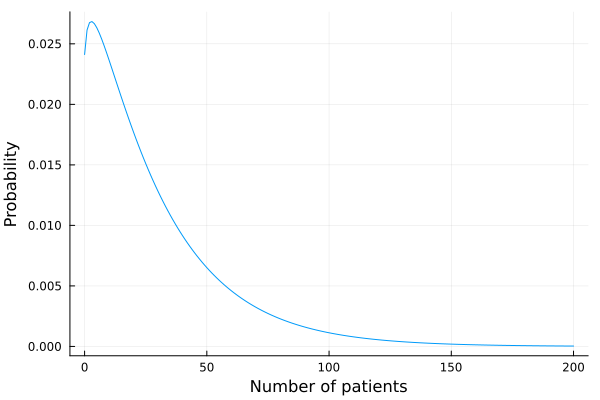

In [17]:
ctry_pmf = pmf(ctry)
pltrange = 0:200

x = pltrange
y = ctry_pmf[pltrange .+ 1]

plot(x, y, xlabel = "Number of patients", ylabel = "Probability", legend = false)

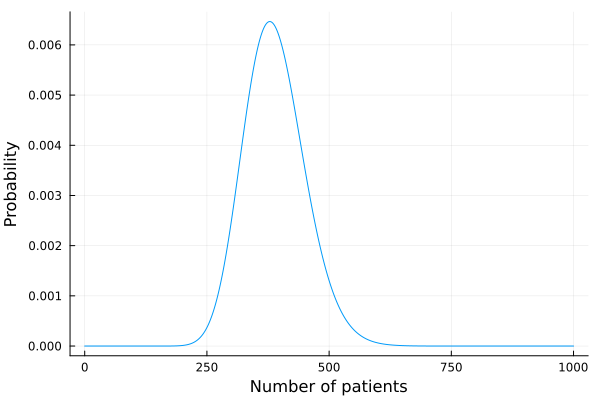

In [18]:
ct_pmf = pmf(ct)
pltrange = 0:1000

x = pltrange
y = ct_pmf[pltrange .+ 1]

plot(x, y, xlabel = "Number of patients", ylabel = "Probability", legend = false)

### `cdf`

```@docs
cdf
```

Example use:

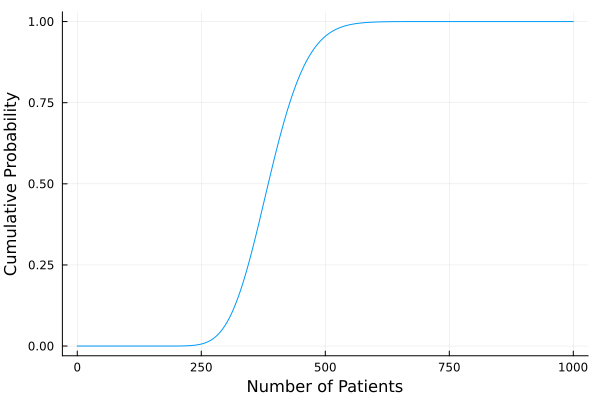

In [19]:
x = [0:1:1000;]
y = Vector{Float64}(undef, 1001)

for n in 1:1001
    y[n] = cdf(ct, n - 1)
end

plot(x, y, xlabel = "Number of Patients", ylabel = "Cumulative Probability", legend = false)

### `ccdf`

```@docs
ccdf
```

Example use:

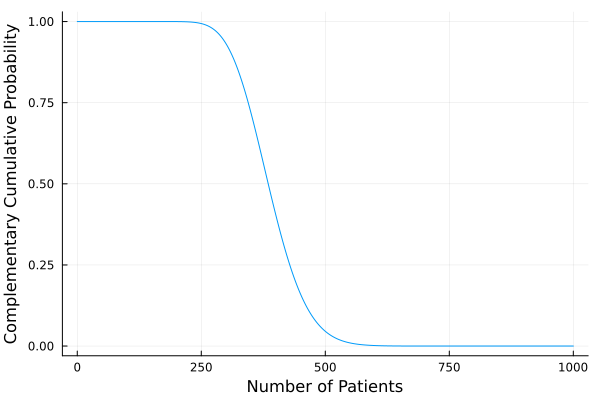

In [20]:
x = [0:1:1000;]
y = Vector{Float64}(undef, 1001)

for n in 1:1001
    y[n] = ccdf(ct, n - 1)
end

plot(x, y, xlabel = "Number of Patients", ylabel = "Complementary Cumulative Probability", 
    legend = false)

## Example Case

With individual examples shown for all functions in the package, here is an example workflow of ClinicalTrialOptm.jl using estimated parameters.

In [21]:
m = [1, 1.2, 1.4, 1.9]
s² = [1.5, 1.7, 1.3, 1.1]
l = [0, 4, 2, 1]
u = [10, 24, 20, 15]
c₀ = [19000.0, 15000.0, 14000.0, 16000.0]
c = [7000.0, 5000.0, 5000.0, 6000.0]
q = [1000.0, 2000.0, 1500.0, 1600.0]
d = [0.10, 0.09, 0.04, 0.07]
T₀ = fill(Uniform(0.0, 6.0), 4)
Td = 12.0
ct = ClinicalTrial(m, s², l, u, c₀, c, q, d, T₀, Td)


Global Clinical Trial:

Optimal center assignment not computed.
┌─────────┬─────────┬────────┬────────────┬────────────────┬──────────────┬───────────────┬──────────────┬──────────────┬─────────┐
│ Country │ mean(λ) │ var(λ) │ init. cost │    maint. cost │ enroll. cost │ drop out rate │ min. centers │ max. centers │ centers │
│         │         │        │   $/center │ $/center/month │    $/patient │               │              │              │         │
├─────────┼─────────┼────────┼────────────┼────────────────┼──────────────┼───────────────┼──────────────┼──────────────┼─────────┤
│       1 │    1.00 │   1.50 │      19000 │           7000 │         1000 │          0.10 │            0 │           10 │      NA │
│       2 │    1.20 │   1.70 │      15000 │           5000 │         2000 │          0.09 │            4 │           24 │      NA │
│       3 │    1.40 │   1.30 │      14000 │           5000 │         1500 │          0.04 │            2 │           20 │      NA │
│       4 │

Solving for the optimal trial design:

In [22]:
optdes!(ct, 400, ps = 0.95)

Lower bound probability of success: 7.112034326831168e-28
The optimal solution is not the lower bound of the centers.
Upper bound probability of success: 0.9999940867534107
The optimal solution is feasible.
  0.026162 seconds (2.16 k allocations: 57.289 KiB)
solution_summary(model) = * Solver : SCIP

* Status
  Result count       : 7
  Termination status : OPTIMAL
  Message from the solver:
  "SCIP_STATUS_OPTIMAL"

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : 3.27739e+06
  Objective bound    : 3.27739e+06
  Relative gap       : 0.00000e+00

* Work counters
  Solve time (sec)   : 2.14900e-02
  Simplex iterations : 89
  Node count         : 28

termination_status(model) = MathOptInterface.OPTIMAL
primal_status(model) = MathOptInterface.FEASIBLE_POINT
objective_value(model) = 3.277387200000001e6



Global Clinical Trial:

Optimal center assignment calculated.
An optimal solution has been found.
Total duration (months): 12.0
Target enrollment: 400
Probability of success (based on normal approximation): 0.9550669693996681
Probability of success (based on Poisson-Gamma model): 0.9636054293917478
Expected cost ($): 3.2773872e6
┌─────────┬─────────┬────────┬────────────┬────────────────┬──────────────┬───────────────┬──────────────┬──────────────┬─────────┐
│ Country │ mean(λ) │ var(λ) │ init. cost │    maint. cost │ enroll. cost │ drop out rate │ min. centers │ max. centers │ centers │
│         │         │        │   $/center │ $/center/month │    $/patient │               │              │              │         │
├─────────┼─────────┼────────┼────────────┼────────────────┼──────────────┼───────────────┼──────────────┼──────────────┼─────────┤
│       1 │    1.00 │   1.50 │      19000 │           7000 │         1000 │          0.10 │            0 │           10 │       0 │
│       

From `optdes!`, we determine that 0 centers should be placed in country 1, 5 centers should be placed in country 2, 20 in country 3, and 14 in country 4 to minimize the trial cost and ensure a high success rate with recruitment.

We can also visualize how the normal approximation of total patient recruitment compares to the more accurate Poisson-Gamma model by plotting the normal distribution, with `mean(ct)` and `var(ct)`, against `pmf(ct)`. 

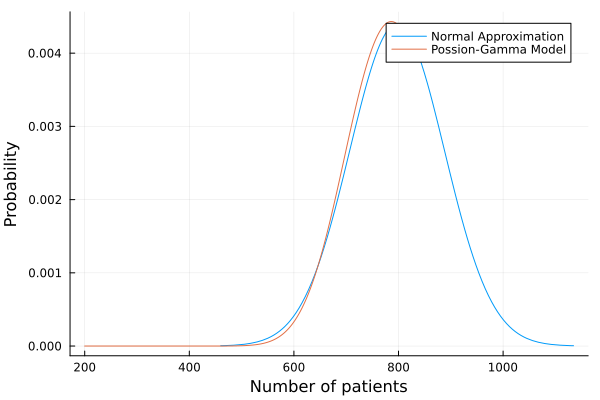

In [24]:
# normal approximation
μ = mean(ct)
σ = sqrt(var(ct))
plot(Normal(μ, σ), label = "Normal Approximation")

# adding the poisson-gamma model
ct_pmf = pmf(ct)
pltrange = 200:800

x = pltrange
y = ct_pmf[pltrange .+ 1]

plot!(x, y, xlabel = "Number of patients", ylabel = "Probability", 
    label = "Possion-Gamma Model")

From the graph, the functions are very similar, demonstrating that the normal approximation works well in calculating the patient enrollment.